In [6]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from IPython.utils import io

import numpy as np
import shap

plt.ion()   # interactive mode


def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

feature_extract = True
num_classes = 4

batch_size=32

# PATH = "models/small-dataset"
PATH = r"I:\Research\House\Dataset\resnet84.pth"
SAVE_PATH = r"X:\Shared drives\Group_research\Story_research\Code\shap"
mode = "resnet"
data_dir = "K:\Research\House\Huan\dataset"


if mode == "resnet":
    model_ft = models.resnet101(pretrained=True)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 224
    model_ft.load_state_dict(torch.load(PATH))
elif mode == "squeezenet":
    model_ft = models.squeezenet1_0(pretrained=True)
    set_parameter_requires_grad(model_ft, feature_extract)
    model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
    model_ft.num_classes = num_classes
    input_size = 224
    model_ft.load_state_dict(torch.load(PATH))
elif mode == "vgg":    
    model_ft = models.vgg11_bn(pretrained=True)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    input_size = 224
    model_ft.load_state_dict(torch.load(PATH))
    
    
    
    


# In[24]:


# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=8) for x in ['train', 'val']}
dataloaders = dataloaders_dict
class_names = image_datasets['train'].classes

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Send the model to GPU
model_ft = model_ft.to(device)

train_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=True, num_workers=0)

def reverse(inp): # image vector to image
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

Initializing Datasets and Dataloaders...
cuda:0


In [7]:
len(test_loader)

139

DeepExplainer

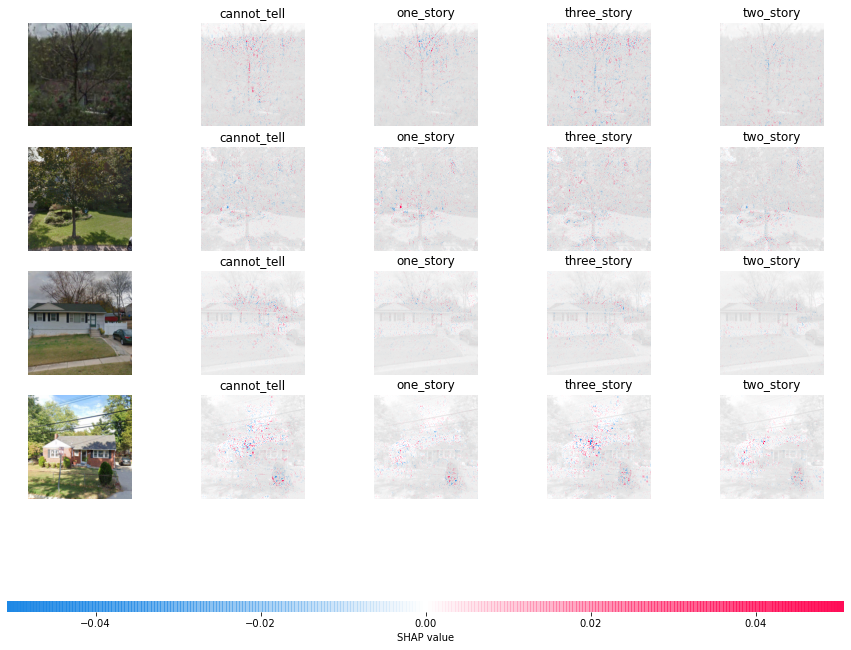

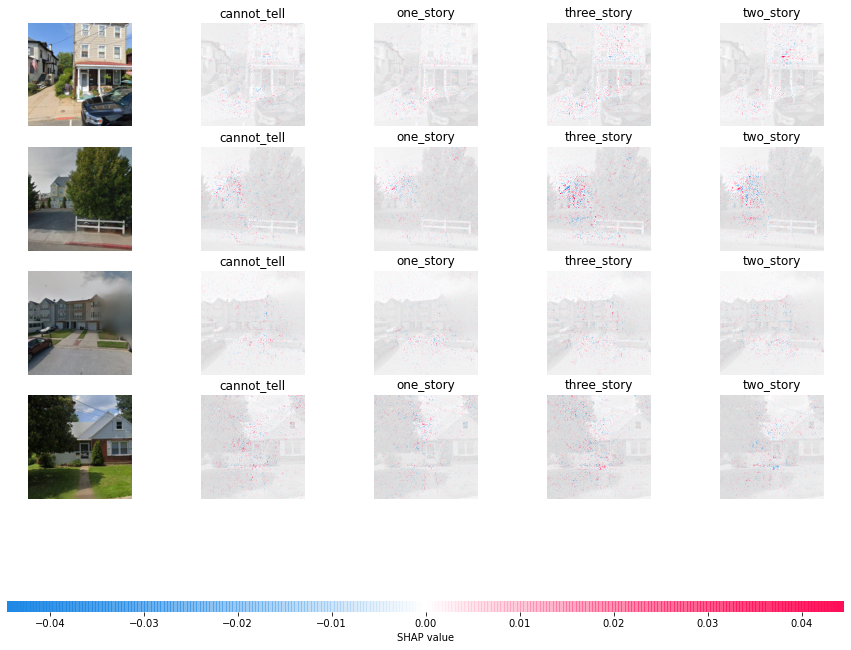

KeyboardInterrupt: 

In [4]:
SAVE_PATH = r"X:\Shared drives\Group_research\Story_research\Code\shap\Deep"
n_test_images = 4
selected_cnt = batch_size - n_test_images
for batch in test_loader:
    images, labels = batch
    background = images[:selected_cnt]
    test_images = images[selected_cnt: selected_cnt + n_test_images]
    classified = labels[selected_cnt: selected_cnt + n_test_images]
    e = shap.DeepExplainer(model_ft.cuda(), background.cuda())
    pred = []
    with io.capture_output() as captured: # Suppress output
        shap_values = e.shap_values(test_images);
        _, pred = e.shap_values(test_images, ranked_outputs=True);
    images = []
    for image in test_images:
        images.append(reverse(image))
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)
    np.array(test_numpy).shape
    labels = np.array([class_names] * n_test_images)
    
    labels = np.array([class_names for i in range(4)])
    
    plt.show()


#     labels = np.array([["actual: " + class_names[classified[i]], "pred: " + class_names[pred[i]], "", ''] for i in range(4)])
    shap.image_plot(shap_numpy, np.array(images), labels = labels, show=True)
    plt.figure(figsize=(18, 18))
    
     
    plt.savefig(f"{SAVE_PATH}\\{hash(tuple(batch))}.png")
    plt.close()
    torch.cuda.empty_cache()
    
#     break

4
4
4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


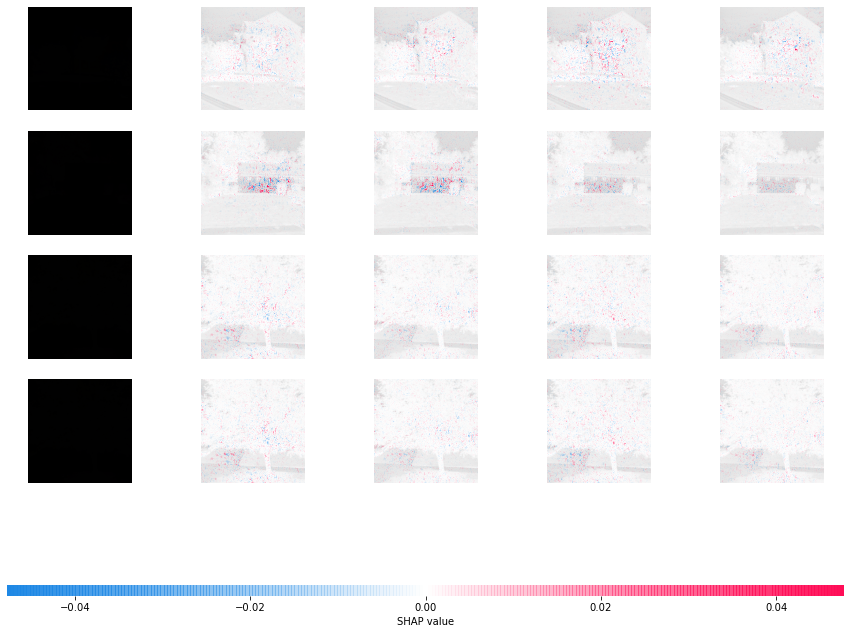

KeyboardInterrupt: 

In [5]:
SAVE_PATH = r"X:\Shared drives\Group_research\Story_research\Code\shap\Gradient"
n_test_images = 4
selected_cnt = batch_size - n_test_images
for batch in test_loader:
    images, labels = batch
    background = images[:selected_cnt]
    test_images = images[selected_cnt: selected_cnt + n_test_images]
    classified = labels[selected_cnt: selected_cnt + n_test_images]
    
    e = shap.DeepExplainer(model_ft.cuda(), background.cuda())
    
    shap_values = e.shap_values(test_images);
    
    print(len(shap_values))
   
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)
    
    print(len(test_numpy))
    print(len(shap_numpy))

    shap.image_plot(shap_numpy, -test_numpy)
    plt.show()
    
    torch.cuda.empty_cache()

Gradient Explainer


In [11]:
SAVE_PATH = r"X:\Shared drives\Group_research\Story_research\Code\shap\Gradient"
i = 0
n_test_images = 4
selected_cnt = batch_size - n_test_images
for batch in test_loader:
    images, labels = batch
    background = images[:selected_cnt]
    test_images = images[selected_cnt: selected_cnt + n_test_images]
    classified = labels[selected_cnt: selected_cnt + n_test_images]
    
    e = shap.GradientExplainer(model_ft.cuda(), background.cuda())
    pred = []
    with io.capture_output() as captured: # Suppress output
        shap_values,indexes = e.shap_values(test_images.cuda(), ranked_outputs=4, nsamples=256)
        
    images = []
    for image in test_images:
        images.append(reverse(image))
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    
#     index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes.cpu())
    
    labels = np.array([["actual: " + class_names[classified[i]] + ", pred: " + class_names[indexes[i][0]], '', "" ,""] for i in range(n_test_images)])
    
    shap.image_plot(shap_numpy, np.array(images), labels, show=False)
    
    plt.savefig(os.path.join(SAVE_PATH, f"Gradient_batch{i}.png"))
    
    i += 1
    plt.close()
    
    torch.cuda.empty_cache()
    print(i)
#     plt.show()
    
#     break

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138


RuntimeError: non-empty 3D or 4D input tensor expected but got ndim: 4

In [28]:
n_test_images = 10
for batch in test_loader:
    images, labels = batch
    background = images[:50]
    test_images = images[50:50 + n_test_images]
    classified = labels[50:n_test_images]
    
    e = shap.GradientExplainer(model_ft.cuda(), background.cuda())
    pred = []
    with io.capture_output() as captured: # Suppress output
        shap_values,indexes = e.shap_values(test_images.cuda(), ranked_outputs=2, nsamples=50)
    images = []
    for image in test_images:
        images.append(reverse(image))
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    labels = np.array([["" + class_names[classified[i]] + "->" + class_names[indexes[i][0]], "" + class_names[classified[i]] + "-> " + class_names[indexes[i][1]]] for i in range(3)])
    shap.image_plot(shap_numpy, np.array(images), labels=labels, show=True)
    plt.savefig(f"{SAVE_PATH}{hash(tuple(batch))}.png")
    plt.close()
    torch.cuda.empty_cache()
    # plt.show()
#     break

RuntimeError: non-empty 3D or 4D input tensor expected but got ndim: 4

In [ ]:
# kim New 


In [0]:
batch = next(iter(test_loader))

In [0]:
pred

tensor([[4],
        [0],
        [0],
        [0]], device='cuda:0')

In [0]:
shap_values,indexes = e.shap_values(test_images.cuda(), ranked_outputs=2, nsamples=200)

In [0]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

IndexError: index 4 is out of bounds for axis 0 with size 4

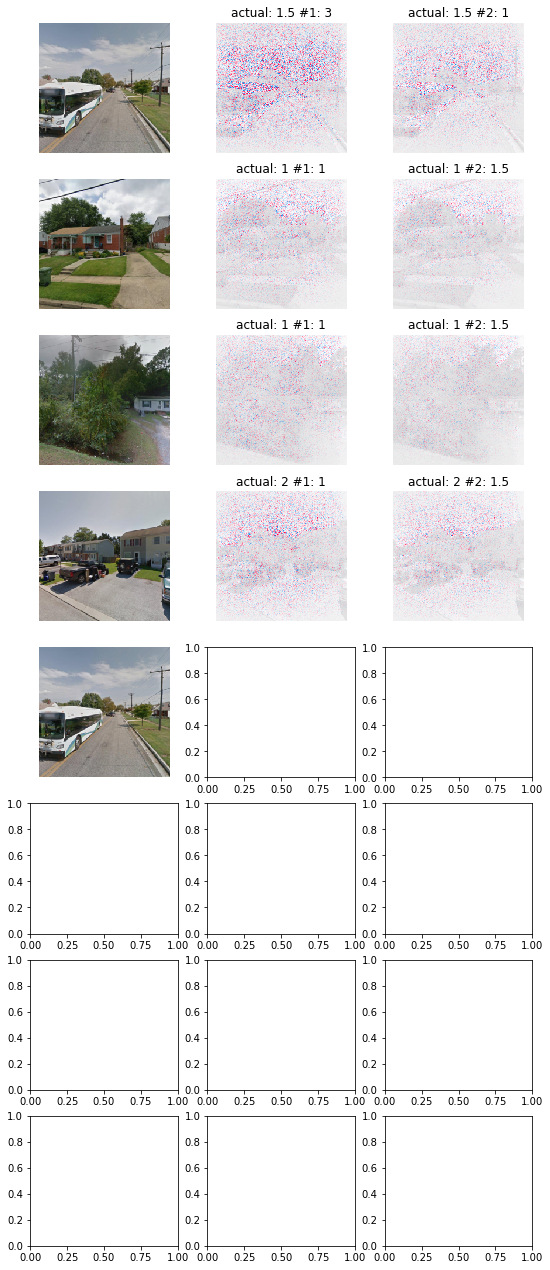

In [0]:
labels = np.array([["actual: " + class_names[classified[i]] + " #1: " + class_names[indexes[i][0]], "actual: " + class_names[classified[i]] + " #2: " + class_names[indexes[i][1]]] for i in range(4)])
shap.image_plot(shap_numpy, np.array(images), labels=labels, show=True)

In [0]:
indexes

tensor([[4, 0],
        [0, 1],
        [0, 1],
        [0, 1]], device='cuda:0')